In [1]:
import pandas as pd

# Load the Excel file
file_path = 'https://docs.google.com/spreadsheets/d/1R7kmn9LtcGZFUCplZVN804NXsGWyUBHF/export?format=xlsx'
sheet_name = 'combinedata'

# Read the specific sheet into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the DataFrame
df.head()


,Question,Answer
0,"Ẹ ǹlẹ́ o, Ẹlẹ́ran.","Ẹ ǹlẹ́ o, Oníbàárà."
1,Ṣé ajé ń wọgbá?,Olúwa ṣeun.
2,Eélòó ni kilo ẹran?,ẹgbẹ̀rún meji ati abo naira ni kílò.
3,Ṣé jálẹ̀jálẹ̀ nì yẹn?,"Bẹ́ẹ̀ni, jálẹ̀jálẹ̀ nì yẹn. Kódà, àwọn kan ń t..."
4,"Ṣe bí o ti mọ, ẹlẹ́wà Ṣàpọn.",Òótó lẹ sọ.


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229 entries, 0 to 1228
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  1229 non-null   object
 1   Answer    1228 non-null   object
dtypes: object(2)
memory usage: 19.3+ KB


In [3]:
df=df.dropna()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1228 entries, 0 to 1228
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  1228 non-null   object
 1   Answer    1228 non-null   object
dtypes: object(2)
memory usage: 28.8+ KB


In [5]:
# Load the data and separate into train, validation and test data
import os
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path

from tqdm import tqdm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Let's now split up the data into train and validation sets
data=df.copy()
n = int(0.9*len(data)) # first 90% will be train, rest val
raw_train_dataset = data[:n]
raw_validation_dataset = data[n:]

In [8]:
#Create tokenizers

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

In [9]:
os.mkdir("./tokenizer_que")
os.mkdir("./tokenizer_ans")

In [10]:
def get_ds_iterator(raw_train_dataset, lang):
    for _, row in raw_train_dataset.iterrows():
        yield row[lang]



In [11]:
# Create Source Tokenizer - Question
tokenizer_en = Tokenizer(BPE(unk_token="[UNK]"))
trainer_en = BpeTrainer(min_frequency=2, special_tokens=["[PAD]","[UNK]","[CLS]", "[SEP]", "[MASK]"])
# We’ll also need to add a pre-tokenizer to split our input into words as without a pre-tokenizer, we might get tokens that overlap several words: for instance we could get a "there is" token since those two words often appear next to each other.
# Using a pre-tokenizer will ensure no token is bigger than a word returned by the pre-tokenizer.
tokenizer_en.pre_tokenizer = Whitespace()
tokenizer_en.train_from_iterator(get_ds_iterator(raw_train_dataset, "Question"), trainer=trainer_en)
tokenizer_en.save("./tokenizer_que/tokenizer_question.json")



In [12]:
# Create Target Tokenizer - answer
tokenizer_my = Tokenizer(BPE(unk_token="[UNK]"))
trainer_my = BpeTrainer(min_frequency=2, special_tokens=["[PAD]","[UNK]","[CLS]", "[SEP]", "[MASK]"])
tokenizer_my.pre_tokenizer = Whitespace()
tokenizer_my.train_from_iterator(get_ds_iterator(raw_train_dataset, "Answer"), trainer=trainer_my)
tokenizer_my.save("./tokenizer_ans/tokenizer_answer.json")


In [13]:
raw_train_dataset[0:1]

,Question,Answer
0,"Ẹ ǹlẹ́ o, Ẹlẹ́ran.","Ẹ ǹlẹ́ o, Oníbàárà."


In [14]:
tokenizer_que = Tokenizer.from_file("./tokenizer_que/tokenizer_question.json")
tokenizer_ans = Tokenizer.from_file("./tokenizer_ans/tokenizer_answer.json")

source_vocab_size = tokenizer_que.get_vocab_size()
target_vocab_size = tokenizer_ans.get_vocab_size()

# to calculate the max sequence lenth in the entire training dataset for the source and target dataset
max_seq_len_source = 0
max_seq_len_target = 0

for  _, data in raw_train_dataset.iterrows():
    enc_ids = tokenizer_en.encode(data['Question']).ids
    dec_ids = tokenizer_my.encode(data['Answer']).ids
    max_seq_len_source = max(max_seq_len_source, len(enc_ids))
    max_seq_len_target = max(max_seq_len_target, len(dec_ids))

print(f'max_seqlen_source: {max_seq_len_source}')   #99 - can be different in your case
print(f'max_seqlen_target: {max_seq_len_target}')   #109 - can be different in your case

# to make it standard for our training we'll just take max_seq_len_source and add 20-50 to cover the additional tokens such as PAD, CLS, SEP
max_seq_len = 225

max_seqlen_source: 81
max_seqlen_target: 175


In [15]:


# Transform raw dataset to the encoded dataset that can be processed by the model
class EncodeDataset(Dataset):
    def __init__(self, raw_dataset, max_seq_len):
        super().__init__()
        self.raw_dataset = raw_dataset
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.raw_dataset)

    def __getitem__(self, index):

        # fetching the single data for the given index value that consist of both question and response.
        raw_text = self.raw_dataset.iloc[index]

        # separating text by question and answer which will be later used for encoding.
        source_text = raw_text["Question"]
        target_text = raw_text['Answer']

        # Encoding both question and answer text
        source_text_encoded = tokenizer_en.encode(source_text).ids
        target_text_encoded = tokenizer_my.encode(target_text).ids

        # Convert the CLS, SEP and PAD tokens to their corresponding index id in vocabulary using tokenizer [the id would be same with either tokenizers]
        CLS_ID = torch.tensor([tokenizer_my.token_to_id("[CLS]")], dtype=torch.int64)
        SEP_ID = torch.tensor([tokenizer_my.token_to_id("[SEP]")], dtype=torch.int64)
        PAD_ID = torch.tensor([tokenizer_my.token_to_id("[PAD]")], dtype=torch.int64)

        # To train the model, the sequence lenth of each input should be equal max seq length. Hence additional number of padding will be added to the input sequence if the length is not equal to the max seq length.
        num_source_padding = self.max_seq_len - len(source_text_encoded) - 2
        num_target_padding = self.max_seq_len - len(target_text_encoded) - 1

        encoder_padding = torch.tensor([PAD_ID] * num_source_padding, dtype = torch.int64)
        decoder_padding = torch.tensor([PAD_ID] * num_target_padding, dtype = torch.int64)

        # encoder_input has the first token as start of senstence - CLS_ID, followed by source encoding which is then followed by the end of sentence token - SEP.
        # To reach the required max_seq_len, addition PAD token will be added at the end.
        encoder_input = torch.cat([CLS_ID, torch.tensor(source_text_encoded, dtype=torch.int64), SEP_ID, encoder_padding], dim=0)

        # decoder_input has the first token as start of senstence - CLS_ID, followed by target encoding.
        # To reach the required max_seq_len, addition PAD token will be added at the end. There is no end of sentence token - SEP in decoder input.
        decoder_input = torch.cat([CLS_ID, torch.tensor(target_text_encoded, dtype=torch.int64), decoder_padding ], dim=0)

        # target_label is required for the loss calculation during training to compare between the predicted and target label.
        # target_label has the first token as target encoding followed by actual target encoding. There is no start of sentence token - CLS in target label.
        # To reach the required max_seq_len, addition PAD token will be added at the end.
        target_label = torch.cat([torch.tensor(target_text_encoded, dtype=torch.int64),SEP_ID,decoder_padding], dim=0)

        # Since we've added extra padding token with input encoding, we don't want this token to be trained by model.
        # So, we'll use encoder mask to nullify the padding value prior to producing output of self attention in encoder block
        encoder_mask = (encoder_input != PAD_ID).unsqueeze(0).unsqueeze(0).int()

        # We don't want any token to get influence the future token during the decoding stage. Hence, Causal mask is being implemented during masked multihead attention to handle this.
        decoder_mask = (decoder_input != PAD_ID).unsqueeze(0).unsqueeze(0).int() & causal_mask(decoder_input.size(0))

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'target_label': target_label,
            'encoder_mask': encoder_mask,
            'decoder_mask': decoder_mask,
            'source_text': source_text,
            'target_text': target_text
        }

# Causal mask will make sure any token that comes after the current token will be masked meaning the value will be replaced by -infinity that will be converted to zero or neearly zero after softmax operation. Hence the model will just ignore these value or willn't be able to learn anything.
def causal_mask(size):
        # Creating a square matrix of dimensions 'size x size' filled with ones
        mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
        return mask == 0

# create a dataloader to use for model training and validation
train_ds = EncodeDataset(raw_train_dataset, max_seq_len)
val_ds = EncodeDataset(raw_validation_dataset, max_seq_len)

train_dataloader = DataLoader(train_ds, batch_size = 5, shuffle = True)
val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)

In [16]:
import torch
import torch.nn as nn
import math

#  Input embedding and positional encoding
class EmbeddingLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        # using pytorch models embedding layer to map token id to embedding vector which has the shape of (vocab_size, d_model)
        # The vocab_size is the vocabulary size of the training data created by tokenizer in step 2
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, input):
        # In addition of giving input to the embedding, the extra multiplication by square root of d_model is to normalize the embedding layer output
        embedding_output = self.embedding(input) * math.sqrt(self.d_model)
        return embedding_output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_seq_len: int, dropout_rate: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        pe = torch.zeros(max_seq_len, d_model)

        pos = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)

        # since we're expecting the input sentences in batches so the extra dimension to cater batch number needs to be added in 0 postion
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, input_embdding):
        input_embdding = input_embdding + (self.pe[:, :input_embdding.shape[1], :]).requires_grad_(False)   # to prevent from calculating gradient
        return self.dropout(input_embdding)

#  Multihead Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout_rate: float):
        super().__init__()
        # Defining dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)
        self.num_heads = num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by number of heads"

        # d_k is the new dimension of each self attention heads
        self.d_k = d_model // num_heads

        # Weight matrix are defined which are all learnable parameters
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

    def forward(self, q, k, v, encoder_mask):

        # Please note that we'll be training our model with not just a single sequence but rather batches of sequence, hence we'll include batch_size in the shape
        # query, Key and value are calculated by matrix multiplication of corresponding weights with the input embeddings
        # Change of shape: q(batch_size, seq_len, d_model) @ W_q(d_model, d_model) => query(batch_size, seq_len, d_model) [same goes to key and value]
        query = self.W_q(q)
        key = self.W_k(k)
        value = self.W_v(v)

        # Dividing query, key and value into number of heads, hence new dimenstion will be d_k.
        # Change of shape: query(batch_size, seq_len, d_model) => query(batch_size, seq_len, num_heads, d_k) -> query(batch_size,num_heads, seq_len,d_k) [same goes to key and value]
        query = query.view(query.shape[0], query.shape[1], self.num_heads ,self.d_k).transpose(1,2)
        key = key.view(key.shape[0], key.shape[1], self.num_heads ,self.d_k).transpose(1,2)
        value = value.view(value.shape[0], value.shape[1], self.num_heads ,self.d_k).transpose(1,2)

        # :: SELF ATTENTION BLOCK STARTS ::

        # Attention score is calculated to find the similarity or relation of query with key of itself and all other embedding in the sequence
        #  Change of shape: query(batch_size,num_heads, seq_len,d_k) @ key(batch_size,num_heads, seq_len,d_k) => attention_score(batch_size,num_heads, seq_len,seq_len)
        attention_score = (query @ key.transpose(-2,-1))/math.sqrt(self.d_k)

        # If mask is provided the attention score needs to modify as per the mask value. Refer to the details in point no 4.
        if encoder_mask is not None:
          attention_score.masked_fill_(encoder_mask==0, -1e9)

        # Softmax operation calculates the probability distribution among all the attention scores. This will determine which embedding is more similar to the given query embedding and assign the attention weight accordingly.
        # Change of shape: same as attention_score
        attention_score = attention_score.softmax(dim=-1)

        if self.dropout is not None:
          attention_score = self.dropout(attention_score)

        # Final step of Self attention block is to matrix multiplication of attention_weight with value embedding.
        # Change of shape: attention_score(batch_size,num_heads, seq_len,seq_len) @  value(batch_size,num_heads, seq_len,d_k) => attention_output(batch_size,num_heads, seq_len,d_k)
        attention_output = attention_score @ value

        # :: SELF ATTENTION BLOCK ENDS ::

        # Now, all the heads will be concated back to for a single head
        # Change of shape:attention_output(batch_size,num_heads, seq_len,d_k) => attention_output(batch_size,seq_len,num_heads,d_k) => attention_output(batch_size,seq_len,d_model)
        attention_output = attention_output.transpose(1,2).contiguous().view(attention_output.shape[0], -1, self.num_heads * self.d_k)

        # Finally attention_output is matrix multiplied with output weight matrix to give the final Multi-Head attention output.
        # The shape of the multihead_output is same as the embedding input
        # Change of shape: attention_output(batch_size,seq_len,d_model) @ W_o(d_model, d_model) => multihead_output(batch_size, seq_len, d_model)
        multihead_output = self.W_o(attention_output)

        return multihead_output

#  Feedfoward Network, Layer Normalization and AddAndNorm

class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout_rate: float):
        super().__init__()

        self.dropout = nn.Dropout(dropout_rate)
        self.layer_1 = nn.Linear(d_model, d_ff)
        self.layer_2 = nn.Linear(d_ff, d_model)

    def forward(self, input):
        return self.layer_2(self.dropout(torch.relu(self.layer_1(input))))

class LayerNorm(nn.Module):
    # def __init__(self, features:int=512, eps: float = 1e-5):
    def __init__(self, eps: float = 1e-5):
        super().__init__()
        # epsilon is a very small value and is plays an important role to avoid division by zero problem
        self.eps = eps
        #Extra learning parameters gamma and beta are introduced to scale and shift the embedding value as the network needed.
        self.gamma = nn.Parameter(torch.ones(512))  # 512 = advisable to initialize with same number as d_model
        self.beta = nn.Parameter(torch.zeros(512))

    def forward(self, input):
        mean = input.mean(dim = -1, keepdim=True)
        std = input.std(dim = -1, keepdim=True)
        return self.gamma * (input - mean)/(std + self.eps) + self.beta

class AddAndNorm(nn.Module):
  def __init__(self, dropout_rate: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = LayerNorm()

  def forward(self, input, sub_layer):
        return input + self.dropout(sub_layer(self.layer_norm(input)))

# Encoder block and Encoder

class EncoderBlock(nn.Module):
    # def __init__(self, features: int, self_attention_block: MultiHeadAttention, feed_forward_block: FeedForward, dropout_rate: float) -> None:
    def __init__(self, multihead_attention: MultiHeadAttention, feed_forward: FeedForward, dropout_rate: float) -> None:
        super().__init__()
        self.multihead_attention = multihead_attention
        self.feed_forward = feed_forward
        self.addnorm_1 = AddAndNorm(dropout_rate)
        self.addnorm_2 = AddAndNorm(dropout_rate)

    def forward(self, encoder_input, encoder_mask):
        # First AddAndNorm unit taking encoder input from skip connection and adding it with the output of MultiHead attention block
        encoder_input = self.addnorm_1(encoder_input, lambda encoder_input: self.multihead_attention(encoder_input, encoder_input, encoder_input, encoder_mask))
        # Second AddAndNorm unit taking output of MultiHead attention block from skip connection and adding it with the output of Feedforward layer
        encoder_input = self.addnorm_2(encoder_input, self.feed_forward)
        return encoder_input

class Encoder(nn.Module):
    def __init__(self, encoderblocklist: nn.ModuleList) -> None:
        super().__init__()
        # Encoder class initialized by taking encoderblock list
        self.encoderblocklist = encoderblocklist
        self.layer_norm = LayerNorm()

    def forward(self, encoder_input, encoder_mask):
        # Looping through all the encoder block - 6 times
        for encoderblock in self.encoderblocklist:
            encoder_input = encoderblock(encoder_input, encoder_mask)
        # Normalize the final encoder block output and return. This encoder output will be used later on as key and value for the cross attention in decoder block
        encoder_output = self.layer_norm(encoder_input)
        return encoder_output

# Decoder block and decoder and the projection

class DecoderBlock(nn.Module):
    # def __init__(self, features: int, self_attention_block: MultiHeadAttention, cross_attention_block: MultiHeadAttention, feed_forward_block: FeedForward, dropout_rate: float) -> None:
    def __init__(self, masked_multihead_attention: MultiHeadAttention, cross_multihead_attention: MultiHeadAttention, feed_forward: FeedForward, dropout_rate: float) -> None:
        super().__init__()
        self.masked_multihead_attention = masked_multihead_attention
        self.cross_multihead_attention = cross_multihead_attention
        self.feed_forward = feed_forward
        self.addnorm_1 = AddAndNorm(dropout_rate)
        self.addnorm_2 = AddAndNorm(dropout_rate)
        self.addnorm_3 = AddAndNorm(dropout_rate)

    def forward(self, decoder_input, encoder_output, encoder_mask, decoder_mask):
        # First AddAndNorm unit taking decoder input from skip connection and adding it with the output of Masked Multi-Head attention block
        decoder_input = self.addnorm_1(decoder_input, lambda decoder_input: self.masked_multihead_attention(decoder_input, decoder_input, decoder_input, decoder_mask))
        # Second AddAndNorm unit taking output of Masked Multi-Head attention block from skip connection and adding it with the output of MultiHead attention block
        decoder_input = self.addnorm_2(decoder_input, lambda decoder_input: self.cross_multihead_attention(decoder_input, encoder_output, encoder_output, encoder_mask))
        # Third AddAndNorm unit taking output of MultiHead attention block from skip connection and adding it with the output of Feedforward layer
        decoder_input = self.addnorm_3(decoder_input, self.feed_forward)
        return decoder_input

class Decoder(nn.Module):
    # def __init__(self, features: int, layers: nn.ModuleList) -> None:
    def __init__(self, decoderblocklist: nn.ModuleList) -> None:
        super().__init__()
        self.decoderblocklist = decoderblocklist
        self.layer_norm = LayerNorm()

    def forward(self, decoder_input, encoder_output, encoder_mask, decoder_mask):
        for decoderblock in self.decoderblocklist:
            decoder_input = decoderblock(decoder_input, encoder_output, encoder_mask, decoder_mask)
        decoder_output = self.layer_norm(decoder_input)
        return decoder_output

class ProjectionLayer(nn.Module):
    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.projection_layer = nn.Linear(d_model, vocab_size)

    def forward(self, decoder_output) -> None:
        # Projection layer first take in decoder output and feed into the linear layer of shape (d_model, vocab_size)
        #Change in shape: decoder_output(batch_size, seq_len, d_model) @ linear_layer(d_model, vocab_size) => output(batch_size, seq_len, vocab_size)
        output = self.projection_layer(decoder_output)
        return output

# Create and build Transfomer

class Transformer(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, source_embed: EmbeddingLayer, target_embed: EmbeddingLayer, source_pos: PositionalEncoding, target_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()

        self.source_embed = source_embed
        self.source_pos = source_pos
        self.encoder = encoder

        self.target_embed = target_embed
        self.target_pos = target_pos
        self.decoder = decoder

        self.projection_layer = projection_layer

    def encode(self, encoder_input, encoder_mask):
        encoder_input = self.source_embed(encoder_input)
        encoder_input = self.source_pos(encoder_input)
        encoder_output = self.encoder(encoder_input, encoder_mask)
        return encoder_output

    def decode(self, encoder_output, encoder_mask, decoder_input, decoder_mask):
        decoder_input = self.target_embed(decoder_input)
        decoder_input = self.target_pos(decoder_input)
        decoder_output = self.decoder(decoder_input, encoder_output, encoder_mask, decoder_mask)
        return decoder_output

    def project(self, decoder_output):
        return self.projection_layer(decoder_output)

def build_model(source_vocab_size: int, target_vocab_size: int, source_seq_len: int, target_seq_len: int, d_model: int=512, num_blocks: int=6, num_heads: int=8, dropout_rate: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    source_embed = EmbeddingLayer(d_model, source_vocab_size)
    target_embed = EmbeddingLayer(d_model, target_vocab_size)

    # Create the positional encoding layers
    source_pos = PositionalEncoding(d_model, source_seq_len, dropout_rate)
    target_pos = PositionalEncoding(d_model, target_seq_len, dropout_rate)

    # Create the encoder-block-list
    encoderblocklist = []
    for _ in range(num_blocks):
        multihead_attention = MultiHeadAttention(d_model, num_heads, dropout_rate)
        feed_forward = FeedForward(d_model, d_ff, dropout_rate)
        encoder_block = EncoderBlock(multihead_attention, feed_forward, dropout_rate)
        encoderblocklist.append(encoder_block)
    # Create the encoder
    encoder = Encoder(nn.ModuleList(encoderblocklist))

    # Create the decoder-block-list
    decoderblocklist = []
    for _ in range(num_blocks):
        masked_multihead_attention = MultiHeadAttention(d_model,num_heads, dropout_rate)
        cross_multihead_attention = MultiHeadAttention(d_model, num_heads, dropout_rate)
        feed_forward = FeedForward(d_model, d_ff, dropout_rate)
        decoder_block = DecoderBlock(masked_multihead_attention, cross_multihead_attention, feed_forward, dropout_rate)
        decoderblocklist.append(decoder_block)
    # Create the decoder
    decoder = Decoder(nn.ModuleList(decoderblocklist))

    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, target_vocab_size)

    # Now that we've initialized all the required blocks of transformer, we can now inititiate a model
    model = Transformer(encoder, decoder, source_embed, target_embed, source_pos, target_pos, projection_layer)

    # For the first time, we'll initialize the model parameters using xavier uniform method. Once training begings the parameters will be updated by the network
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return model

In [17]:

# Let's build the model.
model = build_model(tokenizer_en.get_vocab_size(), tokenizer_my.get_vocab_size(),max_seq_len, max_seq_len, d_model=512).to(device)

# Let's look at the architecture that we've just build ourself
print(model)

Transformer(
  (source_embed): EmbeddingLayer(
    (embedding): Embedding(1308, 512)
  )
  (source_pos): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (encoderblocklist): ModuleList(
      (0-5): 6 x EncoderBlock(
        (multihead_attention): MultiHeadAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (W_q): Linear(in_features=512, out_features=512, bias=False)
          (W_k): Linear(in_features=512, out_features=512, bias=False)
          (W_v): Linear(in_features=512, out_features=512, bias=False)
          (W_o): Linear(in_features=512, out_features=512, bias=False)
        )
        (feed_forward): FeedForward(
          (dropout): Dropout(p=0.1, inplace=False)
          (layer_1): Linear(in_features=512, out_features=2048, bias=True)
          (layer_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (addnorm_1): AddAndNorm(
          (dropout): Dropout(p=0.1, inplace=False)
         

In [18]:
os.mkdir("./Yorubagpt")

In [19]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

In [20]:
%%time
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 16.2 µs


In [ ]:
#from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [21]:
import time
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import numpy as np

# Define the validation function
def run_validation(model, validation_ds, tokenizer_en, tokenizer_my, max_seq_len, device, print_msg, global_step):
    model.eval()
    count = 0
    reference_texts = []
    generated_texts = []

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["encoder_input"].to(device)
            encoder_mask = batch["encoder_mask"].to(device)

            cls_id = tokenizer_my.token_to_id('[CLS]')
            sep_id = tokenizer_my.token_to_id('[SEP]')

            # Computing the output of the encoder for the source sequence
            encoder_output = model.encode(encoder_input, encoder_mask)
            # for prediction task, the first token that goes in decoder input is the [CLS] token
            decoder_input = torch.empty(1, 1).fill_(cls_id).type_as(encoder_input).to(device)
            # since we need to keep adding the output back to the input until the [SEP] - end token is received.
            while True:
                # check if the max length is received
                if decoder_input.size(1) == max_seq_len:
                    break

                # recreate mask each time the new output is added the decoder input for next token prediction
                decoder_mask = causal_mask(decoder_input.size(1)).type_as(encoder_mask).to(device)

                # apply projection only to the next token
                out = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)

                # apply projection only to the next token
                prob = model.project(out[:, -1])

                # select the token with highest probability which is a greedy search implementation
                _, next_word = torch.max(prob, dim=1)
                decoder_input = torch.cat(
                    [decoder_input, torch.empty(1, 1).type_as(encoder_input).fill_(next_word.item()).to(device)], dim=1
                )
                # check if the new token is the end of token
                if next_word == sep_id:
                    break
            # final output is the concatenated decoder input till the end token is reached
            model_out = decoder_input.squeeze(0)

            source_text = batch["source_text"][0]
            target_text = batch["target_text"][0]
            model_out_text = tokenizer_my.decode(model_out.detach().cpu().numpy())

            reference_texts.append(target_text)
            generated_texts.append(model_out_text)

            # Print the source, target, and model output
            print_msg('-'*55)
            print_msg(f'Source Text: {source_text}')
            print_msg(f'Target Text: {target_text}')
            print_msg(f'Predicted by YorubaChatbot: {model_out_text}')

            if count == 2:
                break

    # Compute BLEU score
    bleu_score = compute_bleu_score(reference_texts, generated_texts)
    print_msg(f'BLEU score: {bleu_score:.4f}')

    corpus_bleu_score = corpus_bleu(reference_texts, generated_texts)
    #print(f'Corpus BLEU score: {corpus_bleu_score:.4f}')

    return bleu_score  # Ensure the function returns the BLEU score


def compute_bleu_score(reference_texts, generated_texts):
    """
    Compute the BLEU score for a list of reference texts and generated texts.

    :param reference_texts: List of reference texts (ground truth)
    :param generated_texts: List of generated texts by the model
    :return: BLEU score
    """
    scores = []
    for ref, gen in zip(reference_texts, generated_texts):
        ref_tokens = ref.split()  # Tokenize reference text
        gen_tokens = gen.split()  # Tokenize generated text
        scores.append(sentence_bleu([ref_tokens], gen_tokens))

    return sum(scores) / len(scores) if scores else 0


def train_model(preload_epoch=None):
    # The entire training, validation cycle will run for 60 cycles or epochs.
    EPOCHS = 70
    initial_epoch = 0
    global_step = 0

    # Adam is one of the most commonly used optimization algorithms that hold the current state and will update the parameters based on the computed gradients.
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, eps=1e-9)

    # If the preload_epoch is not none, that means the training will start with the weights, optimizer that has been last saved and start with preload epoch + 1
    if preload_epoch is not None:
        model_filename = f"./Yorubagpt/model_{preload_epoch}.pt"
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']

    # The CrossEntropyLoss loss function computes the difference between the projection output and target label.
    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_en.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

    # Lists to store metrics
    train_losses = []
    val_bleu_scores = []
    cumulative_bleu_scores = []

    for epoch in range(initial_epoch, EPOCHS):
        epoch_start_time = time.time()
        cpu_start_time = time.process_time()

        model.train()
        epoch_loss = 0.0
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:
            encoder_input = batch['encoder_input'].to(device)  # (B, seq_len)
            decoder_input = batch['decoder_input'].to(device)  # (B, seq_len)
            encoder_mask = batch['encoder_mask'].to(device)  # (B, 1, 1, seq_len)
            decoder_mask = batch['decoder_mask'].to(device)  # (B, 1, seq_len, seq_len)
            target_label = batch['target_label'].to(device)  # (B, seq_len)

            # Run the tensors through the encoder, decoder, and the projection layer
            encoder_output = model.encode(encoder_input, encoder_mask)  # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)  # (B, seq_len, d_model)
            projection_output = model.project(decoder_output)  # (B, seq_len, vocab_size)

            # Compute the loss using a simple cross-entropy
            loss = loss_fn(projection_output.view(-1, tokenizer_my.get_vocab_size()), target_label.view(-1))
            epoch_loss += loss.item()
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1

        epoch_loss /= len(train_dataloader)
        train_losses.append(epoch_loss)

        # Calculate CPU time and wall time for the epoch
        cpu_time = time.process_time() - cpu_start_time
        wall_time = time.time() - epoch_start_time
        print(f"Epoch {epoch} - CPU time: {cpu_time:.4f}s, Wall time: {wall_time:.4f}s")

        print(f"Validation for Epoch {epoch}")
        bleu_score = run_validation(model, val_dataloader, tokenizer_en, tokenizer_my, max_seq_len, device, print, global_step)
        val_bleu_scores.append(bleu_score)

        # Compute cumulative BLEU score
        cumulative_bleu = np.cumsum(val_bleu_scores) / (np.arange(len(val_bleu_scores)) + 1)
        cumulative_bleu_scores.append(cumulative_bleu[-1])

        print(f"BLEU score for Epoch {epoch}: {bleu_score:.4f}")
        print(f"Cumulative BLEU score for Epoch {epoch}: {cumulative_bleu[-1]:.4f}")

        # Save the model at the end of every epoch
        model_filename = f"./Yorubagpt/model_{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)

    # Plotting the results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(1, EPOCHS + 1), val_bleu_scores, marker='o', label='Validation BLEU Score', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('BLEU Score')
    plt.title('Validation BLEU Score over Epochs')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(1, EPOCHS + 1), cumulative_bleu_scores, marker='o', label='Cumulative BLEU Score', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Cumulative BLEU Score')
    plt.title('Cumulative BLEU Score over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


Processing Epoch 00: 100%|██████████| 221/221 [00:31<00:00,  6.92it/s, loss=4.681]


Epoch 0 - CPU time: 29.9924s, Wall time: 31.9597s
Validation for Epoch 0
-------------------------------------------------------
Source Text: Ó dàbọ̀.
Target Text: Ẹ seun.
Predicted by YorubaChatbot: Ó dáa .
-------------------------------------------------------
Source Text: Coconut seller, eélòó ni àgbọn?
Target Text: Ogún náírà ni àgbọn.
Predicted by YorubaChatbot: Ó dáa .
BLEU score: 0.0000
BLEU score for Epoch 0: 0.0000
Cumulative BLEU score for Epoch 0: 0.0000


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch 1 - CPU time: 30.4001s, Wall time: 30.9015s
Validation for Epoch 1
-------------------------------------------------------
Source Text: Ẹ ǹlẹ́ o, Ọ̀gá.
Target Text: Ẹ káàsán, sà.
Predicted by YorubaChatbot: Bẹẹni , a ni mo ti o dara .
-------------------------------------------------------
Source Text: Ẹ fi ṣúgà sí i dáadáa.
Target Text: Mi ò kí í po tíì láì sí ṣúgà.
Predicted by YorubaChatbot: Ó dáa .
BLEU score: 0.0000
BLEU score for Epoch 1: 0.0000
Cumulative BLEU score for Epoch 1: 0.0000


Processing Epoch 02: 100%|██████████| 221/221 [00:31<00:00,  7.10it/s, loss=3.926]


Epoch 2 - CPU time: 30.6544s, Wall time: 31.1229s
Validation for Epoch 2
-------------------------------------------------------
Source Text: Bẹ́ẹ̀ náà ni.
Target Text: A máa ń sun orí màlúù kan ní ẹgbẹ̀rún méjì-àbọ̀ náírà, àti orí àgbò ní Ọgọ́rùn-ún márùn-ún náírà (N500), gbogbo rẹ̀ á wá jẹ́ ẹgbẹ̀rún márùn-ún náírà.
Predicted by YorubaChatbot: Ó dáa .
-------------------------------------------------------
Source Text: Ẹ gba Ẹgbẹ̀rún ó lé àádọ́rin naira
Target Text: Ó ku Ọgọ́rùn-ún márùn-ún náírà (N500).
Predicted by YorubaChatbot: Ó dáa .
BLEU score: 0.0000
BLEU score for Epoch 2: 0.0000
Cumulative BLEU score for Epoch 2: 0.0000


Processing Epoch 03: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=1.827]


Epoch 3 - CPU time: 30.4076s, Wall time: 30.8844s
Validation for Epoch 3
-------------------------------------------------------
Source Text: Ó dáa. Ẹ seun. Owó rèé!
Target Text: Ẹ seun o. 
Predicted by YorubaChatbot: Ó dáa .
-------------------------------------------------------
Source Text: Ǹjẹ́ ẹ ni orógbó?
Target Text: Ó wà. Ẹ gbà!
Predicted by YorubaChatbot: Ọgọ́rùn - ún méjì náírà .
BLEU score: 0.0000
BLEU score for Epoch 3: 0.0000
Cumulative BLEU score for Epoch 3: 0.0000


Processing Epoch 04: 100%|██████████| 221/221 [00:31<00:00,  7.10it/s, loss=3.372]


Epoch 4 - CPU time: 30.6407s, Wall time: 31.1297s
Validation for Epoch 4
-------------------------------------------------------
Source Text: Ṣé ẹ ò fẹ́ kí a di oníbàárà ni?
Target Text: Kò rí bẹ́ẹ̀. Nǹkan ló wọ́n.
Predicted by YorubaChatbot: Bẹ́ẹ̀ni , ó wà .
-------------------------------------------------------
Source Text: Eélòó ni bọ́tà Simas?
Target Text: àádóje náírà ni Bọ́tà Simas.
Predicted by YorubaChatbot: Ọgọ́rùn - ún náírà .
BLEU score: 0.0000
BLEU score for Epoch 4: 0.0000
Cumulative BLEU score for Epoch 4: 0.0000


Processing Epoch 05: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=2.805]


Epoch 5 - CPU time: 30.5189s, Wall time: 30.8976s
Validation for Epoch 5
-------------------------------------------------------
Source Text: Eélòó ni ẹ pè é?
Target Text: Ọgọ́rùn-ún méjì náírà.
Predicted by YorubaChatbot: Ọgọ́rùn - ún méjì àti àádọ́ta náírà ni .
-------------------------------------------------------
Source Text: Ṣé pé kò gbá Ọgọ́ta náírà?
Target Text: Kò gbà.
Predicted by YorubaChatbot: Kò gbà .
BLEU score: 0.0000
BLEU score for Epoch 5: 0.0000
Cumulative BLEU score for Epoch 5: 0.0000


Processing Epoch 06: 100%|██████████| 221/221 [00:30<00:00,  7.17it/s, loss=2.863]


Epoch 6 - CPU time: 30.3275s, Wall time: 30.8239s
Validation for Epoch 6
-------------------------------------------------------
Source Text: Ó dáa.
Target Text: Ó dàbọ̀.
Predicted by YorubaChatbot: Ó dàbọ̀ .
-------------------------------------------------------
Source Text: Á hàá, ṣé iye tí ẹ fẹ́ẹ́ tà á nì yẹn?
Target Text: Ọgọ́rùn-ún méjì àti àádọ́ta náírà ni jálẹ̀jálẹ̀.
Predicted by YorubaChatbot: Bẹ́ẹ̀ni , ó wà .
BLEU score: 0.0000
BLEU score for Epoch 6: 0.0000
Cumulative BLEU score for Epoch 6: 0.0000


Processing Epoch 07: 100%|██████████| 221/221 [00:30<00:00,  7.13it/s, loss=2.458]


Epoch 7 - CPU time: 30.5034s, Wall time: 30.9986s
Validation for Epoch 7
-------------------------------------------------------
Source Text: Ó dáa, ẹ pò ó!
Target Text: Ó dáa.
Predicted by YorubaChatbot: Ó dáa .
-------------------------------------------------------
Source Text: Ẹ kú iṣẹ́ o.
Target Text: Ẹ kú àbọ̀ .
Predicted by YorubaChatbot: Ẹ káàbọ̀ , ẹ ni mo ti sọ .
BLEU score: 0.0000
BLEU score for Epoch 7: 0.0000
Cumulative BLEU score for Epoch 7: 0.0000


Processing Epoch 08: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=2.368]


Epoch 8 - CPU time: 30.4266s, Wall time: 30.8875s
Validation for Epoch 8
-------------------------------------------------------
Source Text: Náírà mẹ́wàá kọ́ ni mo pè é. Bá wo ni ti ogún náírà ṣe kéré báyìí?
Target Text: Gbogbo nǹkan ló mà ti wọ́n.
Predicted by YorubaChatbot: Bẹ́ẹ̀ni
-------------------------------------------------------
Source Text: Ṣé eléyìí tó kilo kan?
Target Text: Kilo kan ni.
Predicted by YorubaChatbot: Bẹ́ẹ̀ni , ó wà .
BLEU score: 0.0000
BLEU score for Epoch 8: 0.0000
Cumulative BLEU score for Epoch 8: 0.0000


Processing Epoch 09: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=2.182]


Epoch 9 - CPU time: 30.3526s, Wall time: 30.9292s
Validation for Epoch 9
-------------------------------------------------------
Source Text: Ẹ fi í sílẹ̀ fún mi bẹ́ẹ̀.
Target Text: Ẹ jọ̀ọ́, mi ò lè tà á bẹ́ẹ̀.
Predicted by YorubaChatbot: Ẹ ṣé
-------------------------------------------------------
Source Text: Ǹjẹ́ ẹ ni orógbó?
Target Text: Ó wà. Ẹ gbà!
Predicted by YorubaChatbot: Ó wà
BLEU score: 0.0000
BLEU score for Epoch 9: 0.0000
Cumulative BLEU score for Epoch 9: 0.0000


Processing Epoch 10: 100%|██████████| 221/221 [00:30<00:00,  7.14it/s, loss=1.553]


Epoch 10 - CPU time: 30.4311s, Wall time: 30.9446s
Validation for Epoch 10
-------------------------------------------------------
Source Text: Ọgọ́rùn-ún méje àti àádọ́ta náírà ni màá san.
Target Text: Ó tì.
Predicted by YorubaChatbot: Ó tì .
-------------------------------------------------------
Source Text: N20 kẹ̀? Odindi ńkọ́?
Target Text: Èwo?
Predicted by YorubaChatbot: Èwo ?
BLEU score: 0.0000
BLEU score for Epoch 10: 0.0000
Cumulative BLEU score for Epoch 10: 0.0000


Processing Epoch 11: 100%|██████████| 221/221 [00:30<00:00,  7.13it/s, loss=1.536]


Epoch 11 - CPU time: 30.5999s, Wall time: 30.9993s
Validation for Epoch 11
-------------------------------------------------------
Source Text: Á hàá, ṣé iye tí ẹ fẹ́ẹ́ tà á nì yẹn?
Target Text: Ọgọ́rùn-ún méjì àti àádọ́ta náírà ni jálẹ̀jálẹ̀.
Predicted by YorubaChatbot: Ọgọ́rùn - ún méjì náírà .
-------------------------------------------------------
Source Text: Ọgọ́rùn-ún mẹ́fà náírà ni màá san. Ṣé kì ń san owó?
Target Text: Ẹhn, ẹ mú owó wá.
Predicted by YorubaChatbot: Ẹ jẹ́ kí n wò wọ́n .
BLEU score: 0.0000
BLEU score for Epoch 11: 0.0000
Cumulative BLEU score for Epoch 11: 0.0000


Processing Epoch 12: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=1.454]


Epoch 12 - CPU time: 30.3980s, Wall time: 30.9344s
Validation for Epoch 12
-------------------------------------------------------
Source Text: Ẹ seun.
Target Text: A dúpẹ́.
Predicted by YorubaChatbot: Ó dàbọ̀ .
-------------------------------------------------------
Source Text: Náírà mẹ́wàá kọ́ ni mo pè é. Bá wo ni ti ogún náírà ṣe kéré báyìí?
Target Text: Gbogbo nǹkan ló mà ti wọ́n.
Predicted by YorubaChatbot: Gbogbo nǹkan ló mà ti wọ́n .
BLEU score: 0.3074
BLEU score for Epoch 12: 0.3074
Cumulative BLEU score for Epoch 12: 0.0236


Processing Epoch 13: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=1.514]


Epoch 13 - CPU time: 30.3516s, Wall time: 30.8978s
Validation for Epoch 13
-------------------------------------------------------
Source Text: Bá wo ni ẹ ṣe ń tà á?
Target Text: Bí ẹ bá ṣe fẹ́ ẹ sí ni. A ń ta oní- àádọ́ta náírà ogójì náírà àti ọgbọ̀n náírà.
Predicted by YorubaChatbot: Mo ní semo , tuwo - ún àti àádọ́ta náírà ni àádọ́ta náírà .
-------------------------------------------------------
Source Text: Eélòó ni gúábà?
Target Text: Èyí ọọ́rùn-ún náírà, ìyẹn ọgọ́ta.
Predicted by YorubaChatbot: Èyí ọ ọ́ rùn - ún náírà , ìyẹn ọgọ́ta
BLEU score: 0.0000
BLEU score for Epoch 13: 0.0000
Cumulative BLEU score for Epoch 13: 0.0220


Processing Epoch 14: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=1.526]


Epoch 14 - CPU time: 30.4566s, Wall time: 30.8725s
Validation for Epoch 14
-------------------------------------------------------
Source Text: Ẹ jẹ́ kí a san ogọ́rùn-ún márùn-ún àti àádọ́ta náírà (N550).ọgọ́rùn-ún náírà, àwa náà a lè jẹ èrè àádọ́ta náírà.
Target Text: Àpò mélòó ni ẹ fẹ́?
Predicted by YorubaChatbot: Èwo lẹ fẹ́ ?
-------------------------------------------------------
Source Text: Eélòó ni eléyìí?
Target Text: Ọgọ́rùn-ún náírà ni!
Predicted by YorubaChatbot: Ọgọ́rùn - ún náírà ni !
BLEU score: 0.0000
BLEU score for Epoch 14: 0.0000
Cumulative BLEU score for Epoch 14: 0.0205


Processing Epoch 15: 100%|██████████| 221/221 [00:30<00:00,  7.17it/s, loss=1.323]


Epoch 15 - CPU time: 30.2432s, Wall time: 30.8394s
Validation for Epoch 15
-------------------------------------------------------
Source Text: Ó dáa, mot i mún ìkan.
Target Text: Ó dáa.
Predicted by YorubaChatbot: Ó dàbọ̀ .
-------------------------------------------------------
Source Text: Ọgọ́ta náírà?
Target Text: Kò gbà.
Predicted by YorubaChatbot: Kò gbà .
BLEU score: 0.0000
BLEU score for Epoch 15: 0.0000
Cumulative BLEU score for Epoch 15: 0.0192


Processing Epoch 16: 100%|██████████| 221/221 [00:30<00:00,  7.18it/s, loss=1.332]


Epoch 16 - CPU time: 30.3413s, Wall time: 30.7989s
Validation for Epoch 16
-------------------------------------------------------
Source Text: Coconut seller, eélòó ni àgbọn?
Target Text: Ogún náírà ni àgbọn.
Predicted by YorubaChatbot: Eélòó ni ẹ máa rà á jálẹ̀jálẹ̀ ?
-------------------------------------------------------
Source Text: Ṣé ajé ń wọgbá?
Target Text: A dúpẹ́ lọ́wọ́ Ọlọ́run.
Predicted by YorubaChatbot: Olúwa ṣeun .
BLEU score: 0.0000
BLEU score for Epoch 16: 0.0000
Cumulative BLEU score for Epoch 16: 0.0181


Processing Epoch 17: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=1.434]


Epoch 17 - CPU time: 30.5414s, Wall time: 30.9277s
Validation for Epoch 17
-------------------------------------------------------
Source Text: Àádọ́jọ́ náírà.
Target Text: Mo nílò ohun-mímu ààbọ̀ agolo mílíìkì, ‘Nescafe’, ẹyin méjì àti búrẹ́dì ọgbọ̀n náírà. Eélòó ni gbogbo ẹ̀?
Predicted by YorubaChatbot: Mo nílò ohun - mí mu ààbọ̀ agolo mílíìkì , ‘ Nescafe ’ , ẹ yin méjì àti búr ẹ́ dì ọgbọ̀n náírà . Eélòó ni gbogbo ẹ̀ ?
-------------------------------------------------------
Source Text: Ẹ fi gbogbo rẹ̀ si.
Target Text: Ó dáa.
Predicted by YorubaChatbot: Ó dáa .
BLEU score: 0.0000
BLEU score for Epoch 17: 0.0000
Cumulative BLEU score for Epoch 17: 0.0171


Processing Epoch 18: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=1.344]


Epoch 18 - CPU time: 30.3065s, Wall time: 30.9221s
Validation for Epoch 18
-------------------------------------------------------
Source Text: Eélòó ni odindi?
Target Text: Èwo ni ẹ fẹ́?
Predicted by YorubaChatbot: Èwo ni ẹ fẹ́ ?
-------------------------------------------------------
Source Text: Eélòó ni STALL?
Target Text: Ọgọ́rùn-ún mẹ́ta náírà.
Predicted by YorubaChatbot: Ọgọ́rùn - ún mẹ́ta náírà
BLEU score: 0.0000
BLEU score for Epoch 18: 0.0000
Cumulative BLEU score for Epoch 18: 0.0162


Processing Epoch 19: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=1.247]


Epoch 19 - CPU time: 30.4378s, Wall time: 30.8898s
Validation for Epoch 19
-------------------------------------------------------
Source Text: Ẹ fi gbogbo rẹ̀ si.
Target Text: Ó dáa.
Predicted by YorubaChatbot: Ó dáa .
-------------------------------------------------------
Source Text: Ẹ mú u wá!
Target Text: Mélòó?
Predicted by YorubaChatbot: M élòó ?
BLEU score: 0.0000
BLEU score for Epoch 19: 0.0000
Cumulative BLEU score for Epoch 19: 0.0154


Processing Epoch 20: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=1.247]


Epoch 20 - CPU time: 30.3733s, Wall time: 30.8770s
Validation for Epoch 20
-------------------------------------------------------
Source Text: Ẹhn.
Target Text: Ṣàkì àti ‘roundabout’ ńkọ́?
Predicted by YorubaChatbot: Ṣ à kì àti ‘ roun da bo u t ’ ńkọ́ ?
-------------------------------------------------------
Source Text: Mí ò lè rà á bẹ́ẹ̀.
Target Text: Ẹ̀ ń ná an ní ọgọ́rùn-ún méje àti àádọ́ta náírà. Eélòó ni mo rà á?
Predicted by YorubaChatbot: Ẹ̀ ń ná an ní ọgọ́rùn - ún méje àti àádọ́ta náírà . Eélòó ni mo rà á ?
BLEU score: 0.1901
BLEU score for Epoch 20: 0.1901
Cumulative BLEU score for Epoch 20: 0.0237


Processing Epoch 21: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=1.257]


Epoch 21 - CPU time: 30.3370s, Wall time: 30.9266s
Validation for Epoch 21
-------------------------------------------------------
Source Text: Àádọ́jọ́ náírà.
Target Text: Mo nílò ohun-mímu ààbọ̀ agolo mílíìkì, ‘Nescafe’, ẹyin méjì àti búrẹ́dì ọgbọ̀n náírà. Eélòó ni gbogbo ẹ̀?
Predicted by YorubaChatbot: Mo nílò ohun - mí mu ààbọ̀ agolo mílíìkì , ‘ Nescafe ’ , ẹ yin méjì àti búr ẹ́ dì ọgbọ̀n náírà . Eélòó ni gbogbo ẹ̀ ?
-------------------------------------------------------
Source Text: Ó tì.
Target Text: Ẹ gbà. Ẹ seun o. Ó dàbọ̀.
Predicted by YorubaChatbot: Ẹ gbà . Ẹ seun o . Ó dàbọ̀ .
BLEU score: 0.0000
BLEU score for Epoch 21: 0.0000
Cumulative BLEU score for Epoch 21: 0.0226


Processing Epoch 22: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=1.376]


Epoch 22 - CPU time: 30.4658s, Wall time: 30.9020s
Validation for Epoch 22
-------------------------------------------------------
Source Text: Eléyìí ńkọ́?
Target Text: Ọgọ́rùn-ún náírà.
Predicted by YorubaChatbot: Ọgọ́rùn - ún náírà .
-------------------------------------------------------
Source Text: Ó dáa, ẹ seun.
Target Text: Ẹ̀yin náà seun.
Predicted by YorubaChatbot: Ẹ̀yin náà seun .
BLEU score: 0.0000
BLEU score for Epoch 22: 0.0000
Cumulative BLEU score for Epoch 22: 0.0216


Processing Epoch 23: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=1.219]


Epoch 23 - CPU time: 30.3087s, Wall time: 30.8543s
Validation for Epoch 23
-------------------------------------------------------
Source Text: Eélòó ni jálẹ̀jálẹ̀?
Target Text: Bẹ́ẹ́ni, ọgọ́rùn-ún méjì àti àádọ́ta náírà ni.
Predicted by YorubaChatbot: Jálẹ̀jálẹ̀ nì yẹn .
-------------------------------------------------------
Source Text: Ẹ jọ̀ọ́, mò ń kánjú. Àwọn ọmọ mi ń lọ sí ilé-ìwé láì pẹ́.
Target Text: Bí ẹ ṣe ń ná an, èmi gan-an ò rí i rà bẹ́ẹ̀, ká má ì tíì sọ ti èrè.
Predicted by YorubaChatbot: Bí ẹ ṣe ń ná an , è mi gan - an ò rí i rà bẹ́ẹ̀ , ká má ì tíì sọ ti èrè .
BLEU score: 0.2028
BLEU score for Epoch 23: 0.2028
Cumulative BLEU score for Epoch 23: 0.0292


Processing Epoch 24: 100%|██████████| 221/221 [00:30<00:00,  7.17it/s, loss=1.282]


Epoch 24 - CPU time: 30.3386s, Wall time: 30.8457s
Validation for Epoch 24
-------------------------------------------------------
Source Text: Ọgọ́rùn-ún méje àti àádọ́ta náírà ni màá san.
Target Text: Ó tì.
Predicted by YorubaChatbot: Ó tì .
-------------------------------------------------------
Source Text: Ó dàbọ̀.
Target Text: Ẹ seun.
Predicted by YorubaChatbot: Ó dàbọ̀ .
BLEU score: 0.0000
BLEU score for Epoch 24: 0.0000
Cumulative BLEU score for Epoch 24: 0.0280


Processing Epoch 25: 100%|██████████| 221/221 [00:30<00:00,  7.17it/s, loss=1.276]


Epoch 25 - CPU time: 30.4512s, Wall time: 30.8471s
Validation for Epoch 25
-------------------------------------------------------
Source Text: Hajiya, òun rèé !
Target Text: Ẹ fi ọlọ́gọ́rùn-ún márùn-ún náírà mìíràn si.
Predicted by YorubaChatbot: Ẹ jọ̀ọ́ , ẹ jókòó kí wọ́n gbé ońjẹ náà wá .
-------------------------------------------------------
Source Text: Ọgọ́ta náírà?
Target Text: Kò gbà.
Predicted by YorubaChatbot: Kò gbà .
BLEU score: 0.0000
BLEU score for Epoch 25: 0.0000
Cumulative BLEU score for Epoch 25: 0.0269


Processing Epoch 26: 100%|██████████| 221/221 [00:30<00:00,  7.18it/s, loss=1.269]


Epoch 26 - CPU time: 30.1895s, Wall time: 30.7970s
Validation for Epoch 26
-------------------------------------------------------
Source Text: Ó dáa. Ẹ seun.
Target Text: A dúpẹ́
Predicted by YorubaChatbot: Ó dàbọ̀ .
-------------------------------------------------------
Source Text: Eélòó ni jálẹ̀jálẹ̀?
Target Text: Jálẹ̀jálẹ̀ nì yẹn.
Predicted by YorubaChatbot: B ẹ́ ẹ́ ni , ọgọ́rùn - ún méjì àti àádọ́ta náírà ni .
BLEU score: 0.0000
BLEU score for Epoch 26: 0.0000
Cumulative BLEU score for Epoch 26: 0.0259


Processing Epoch 27: 100%|██████████| 221/221 [00:30<00:00,  7.14it/s, loss=1.298]


Epoch 27 - CPU time: 30.3663s, Wall time: 30.9699s
Validation for Epoch 27
-------------------------------------------------------
Source Text: Àádọ́jọ́ náírà.
Target Text: Mo nílò ohun-mímu ààbọ̀ agolo mílíìkì, ‘Nescafe’, ẹyin méjì àti búrẹ́dì ọgbọ̀n náírà. Eélòó ni gbogbo ẹ̀?
Predicted by YorubaChatbot: Mo nílò ohun - mí mu ààbọ̀ agolo mílíìkì , ‘ Nescafe ’ , ẹ yin méjì àti búr ẹ́ dì ọgbọ̀n náírà . Eélòó ni gbogbo ẹ̀ ?
-------------------------------------------------------
Source Text: Ẹ ǹlẹ́ o, Baba.
Target Text: Pẹ̀lẹ́ o.
Predicted by YorubaChatbot: Ẹ ǹlẹ́ o , ọ̀gá .
BLEU score: 0.0000
BLEU score for Epoch 27: 0.0000
Cumulative BLEU score for Epoch 27: 0.0250


Processing Epoch 28: 100%|██████████| 221/221 [00:30<00:00,  7.14it/s, loss=1.207]


Epoch 28 - CPU time: 30.3863s, Wall time: 30.9695s
Validation for Epoch 28
-------------------------------------------------------
Source Text: Ẹ ò ṣe fún mi lára èyí tí ẹ lé yìí? Èyí. Màá san àádọ́ta náírà.
Target Text: Ó tì.
Predicted by YorubaChatbot: Èwo ?
-------------------------------------------------------
Source Text: Ẹ tà á fún mi bẹ́ẹ̀, ṣe bí oníbàárà yín ni mí.
Target Text: Eélòó ni ẹ máa rà á jálẹ̀jálẹ̀?
Predicted by YorubaChatbot: Eélòó ni ẹ máa rà á jálẹ̀jálẹ̀ ?
BLEU score: 0.3402
BLEU score for Epoch 28: 0.3402
Cumulative BLEU score for Epoch 28: 0.0359


Processing Epoch 29: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=1.317]


Epoch 29 - CPU time: 30.3543s, Wall time: 30.9271s
Validation for Epoch 29
-------------------------------------------------------
Source Text: Ó dáa, ẹ fún mi ní aláàádọ́ta náírà.
Target Text: Ó dáa.
Predicted by YorubaChatbot: Ó dáa .
-------------------------------------------------------
Source Text: Alhaji, ṣé ajé ń wọgbá?
Target Text: A dúpẹ́
Predicted by YorubaChatbot: A dúpẹ́
BLEU score: 0.0000
BLEU score for Epoch 29: 0.0000
Cumulative BLEU score for Epoch 29: 0.0347


Processing Epoch 30: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=1.275]


Epoch 30 - CPU time: 30.5351s, Wall time: 30.9337s
Validation for Epoch 30
-------------------------------------------------------
Source Text: Kí lẹ̀ ń sọ, ẹ̀yin kọ́ lẹ̀ ń tà á ni?
Target Text:  Ṣé kí ń ta aláàádọ́ta náírà fún yín?
Predicted by YorubaChatbot: Ṣé kí n dì ?
-------------------------------------------------------
Source Text: Ẹhn.
Target Text: Ṣàkì àti ‘roundabout’ ńkọ́?
Predicted by YorubaChatbot: Ṣ à kì àti ‘ roun da bo u t ’ ńkọ́ ?
BLEU score: 0.0000
BLEU score for Epoch 30: 0.0000
Cumulative BLEU score for Epoch 30: 0.0336


Processing Epoch 31: 100%|██████████| 221/221 [00:30<00:00,  7.17it/s, loss=1.111]


Epoch 31 - CPU time: 30.1915s, Wall time: 30.8274s
Validation for Epoch 31
-------------------------------------------------------
Source Text: Eélòó ni kilo inú ẹran?
Target Text: Ẹgbẹ̀rún náírà ni kílò.
Predicted by YorubaChatbot: Ẹgbẹ̀rún náírà ni kílò .
-------------------------------------------------------
Source Text: Ṣé kí ń san àádọ́ta náírà fún méjì?
Target Text: Ó tì.
Predicted by YorubaChatbot: Ó tì .
BLEU score: 0.0000
BLEU score for Epoch 31: 0.0000
Cumulative BLEU score for Epoch 31: 0.0325


Processing Epoch 32: 100%|██████████| 221/221 [00:30<00:00,  7.18it/s, loss=1.145]


Epoch 32 - CPU time: 30.3225s, Wall time: 30.7834s
Validation for Epoch 32
-------------------------------------------------------
Source Text: Bẹ́ẹ̀ni.
Target Text: Kí ni ẹ tún fẹ́?
Predicted by YorubaChatbot: N220 .
-------------------------------------------------------
Source Text: Onítíì, ẹ jọ̀ọ́, ẹ fún mi ní tíì!
Target Text: Eélòó ni ààbọ̀ agolo mílíìkì àti ‘Nescafe’
Predicted by YorubaChatbot: Eélòó ni ààbọ̀ agolo mílíìkì àti ‘ Nescafe ’
BLEU score: 0.2937
BLEU score for Epoch 32: 0.2937
Cumulative BLEU score for Epoch 32: 0.0404


Processing Epoch 33: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=1.282]


Epoch 33 - CPU time: 30.3577s, Wall time: 30.9037s
Validation for Epoch 33
-------------------------------------------------------
Source Text: Eélòó ni àpò ilá?
Target Text: Ọgọ́rùn-ún mẹ́fà náírà ni à ń ta àpò. 
Predicted by YorubaChatbot: Ọgọ́rùn - ún mẹ́fà náírà ni à ń ta àpò .
-------------------------------------------------------
Source Text: Eélòó ni àwọn tó wà nínú abọ́ yìí?
Target Text: Eléyìí jẹ́ Ọgọ́rùn-ún mẹ́ta náírà, èyí Ọgọ́rùn-ún márùn-ún náírà.
Predicted by YorubaChatbot: Eléyìí jẹ́ Ọgọ́rùn - ún mẹ́ta náírà , èyí Ọgọ́rùn - ún márùn - ún náírà .
BLEU score: 0.2309
BLEU score for Epoch 33: 0.2309
Cumulative BLEU score for Epoch 33: 0.0460


Processing Epoch 34: 100%|██████████| 221/221 [00:30<00:00,  7.18it/s, loss=1.326]


Epoch 34 - CPU time: 30.3452s, Wall time: 30.7676s
Validation for Epoch 34
-------------------------------------------------------
Source Text: Hajiya, ẹran eélòó ni ẹ fẹ́ rà?
Target Text: Ọgọ́rùn-ún márùn-ún náírà..
Predicted by YorubaChatbot: Ọ̀ rẹ́ mi , ẹ̀yin náà mọ̀ pé ohun gbogbo ló ti wọ́n , ṣùgbọ́n màá tà á fún un yìn ní ẹgbẹ̀run méje àbọ̀ naira .
-------------------------------------------------------
Source Text: Ọlọ́run á sọ òde dẹ̀rọ̀. Ẹ mún ún wá bẹ́ẹ̀.
Target Text: Òhun rè é!
Predicted by YorubaChatbot: Ò hun rè é !
BLEU score: 0.0000
BLEU score for Epoch 34: 0.0000
Cumulative BLEU score for Epoch 34: 0.0447


Processing Epoch 35: 100%|██████████| 221/221 [00:31<00:00,  7.07it/s, loss=1.163]


Epoch 35 - CPU time: 30.4320s, Wall time: 31.2864s
Validation for Epoch 35
-------------------------------------------------------
Source Text: Ńlá.
Target Text: Ọgọ́rùn-ún mẹ́rin náírà ni ńlá.
Predicted by YorubaChatbot: Ọgọ́rùn - ún mẹ́rin náírà ni ń lá .
-------------------------------------------------------
Source Text: Ẹ fi ṣúgà sí i dáadáa.
Target Text: Mi ò kí í po tíì láì sí ṣúgà.
Predicted by YorubaChatbot: Mi ò kí í po tíì lá ì sí ṣúgà .
BLEU score: 0.2399
BLEU score for Epoch 35: 0.2399
Cumulative BLEU score for Epoch 35: 0.0501


Processing Epoch 36: 100%|██████████| 221/221 [00:30<00:00,  7.17it/s, loss=1.152]


Epoch 36 - CPU time: 30.2576s, Wall time: 30.8350s
Validation for Epoch 36
-------------------------------------------------------
Source Text: Mo fẹ́ kí ẹ bá mi sún àwọn nǹkan kan ni
Target Text: Àwọn nǹkan wo?
Predicted by YorubaChatbot: Àwọn nǹkan wo ?
-------------------------------------------------------
Source Text: Bá wo ni ẹ ṣe ń tà á?
Target Text: Bí ẹ bá ṣe fẹ́ ẹ sí ni. A ń ta oní- àádọ́ta náírà ogójì náírà àti ọgbọ̀n náírà.
Predicted by YorubaChatbot: Bí ẹ bá ṣe fẹ́ ẹ sí ni . A ń ta oní - àádọ́ta náírà àti ọgbọ̀n náírà .
BLEU score: 0.2232
BLEU score for Epoch 36: 0.2232
Cumulative BLEU score for Epoch 36: 0.0548


Processing Epoch 37: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=1.189]


Epoch 37 - CPU time: 30.4336s, Wall time: 30.8586s
Validation for Epoch 37
-------------------------------------------------------
Source Text: Eélòó ni àpò ilá?
Target Text: Ọgọ́rùn-ún mẹ́fà náírà ni à ń ta àpò. 
Predicted by YorubaChatbot: Ọgọ́rùn - ún mẹ́fà náírà ni à ń ta àpò .
-------------------------------------------------------
Source Text: Á-hàá! Ọgọ́rùn-ún náírà kẹ̀?
Target Text: Iye ẹ̀ nì yẹn.
Predicted by YorubaChatbot: Iye ẹ̀ nì yẹn .
BLEU score: 0.2309
BLEU score for Epoch 37: 0.2309
Cumulative BLEU score for Epoch 37: 0.0595


Processing Epoch 38: 100%|██████████| 221/221 [00:30<00:00,  7.18it/s, loss=1.138]


Epoch 38 - CPU time: 30.2054s, Wall time: 30.7951s
Validation for Epoch 38
-------------------------------------------------------
Source Text: Ó dàbọ̀.
Target Text: Ẹ seun o.  Ó dàbọ̀.
Predicted by YorubaChatbot: Ó dàbọ̀ .
-------------------------------------------------------
Source Text: Eélòó ni kóńgò ẹ̀pà?
Target Text: Ọgọ́ta náírà.
Predicted by YorubaChatbot: Ọgọ́ta náírà .
BLEU score: 0.0000
BLEU score for Epoch 38: 0.0000
Cumulative BLEU score for Epoch 38: 0.0579


Processing Epoch 39: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=1.134]


Epoch 39 - CPU time: 30.3994s, Wall time: 30.8621s
Validation for Epoch 39
-------------------------------------------------------
Source Text: Ó dáa, ẹ pò ó!
Target Text: Ó dáa.
Predicted by YorubaChatbot: Ó dáa .
-------------------------------------------------------
Source Text: Ṣé wọ́n pọ́n báyìí?
Target Text: Gbogbo wọn ló pọ́n.
Predicted by YorubaChatbot: Gbogbo wọn ló p ọ́n .
BLEU score: 0.0000
BLEU score for Epoch 39: 0.0000
Cumulative BLEU score for Epoch 39: 0.0565


Processing Epoch 40: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=1.170]


Epoch 40 - CPU time: 30.3384s, Wall time: 30.8694s
Validation for Epoch 40
-------------------------------------------------------
Source Text: Àádọ́ta náírà ti pọ̀ jù.
Target Text: Ó ti wọ́n sí ni.
Predicted by YorubaChatbot: Ó ti wọ́n ni sà .
-------------------------------------------------------
Source Text: Eélòó ni ẹ máa tà á jálẹ̀jálẹ̀?
Target Text: Eélòó ni ẹ máa rà á jálẹ̀jálẹ̀?
Predicted by YorubaChatbot: Eélòó ni ẹ máa rà á jálẹ̀jálẹ̀ ?
BLEU score: 0.3402
BLEU score for Epoch 40: 0.3402
Cumulative BLEU score for Epoch 40: 0.0634


Processing Epoch 41: 100%|██████████| 221/221 [00:30<00:00,  7.17it/s, loss=1.129]


Epoch 41 - CPU time: 30.1896s, Wall time: 30.8281s
Validation for Epoch 41
-------------------------------------------------------
Source Text: Mí ò lè rà á bẹ́ẹ̀.
Target Text: Ẹ̀ ń ná an ní ọgọ́rùn-ún méje àti àádọ́ta náírà. Eélòó ni mo rà á?
Predicted by YorubaChatbot: Ẹ̀ ń ná an ní ọgọ́rùn - ún méje àti àádọ́ta náírà . Eélòó ni mo rà á ?
-------------------------------------------------------
Source Text: Onígbàá, ṣé ajé ń wọgbá?
Target Text: A dúpẹ́.
Predicted by YorubaChatbot: A dúpẹ́ lọ́wọ́ Ọlọ́run .
BLEU score: 0.1901
BLEU score for Epoch 41: 0.1901
Cumulative BLEU score for Epoch 41: 0.0664


Processing Epoch 42: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=1.167]


Epoch 42 - CPU time: 30.3714s, Wall time: 30.8835s
Validation for Epoch 42
-------------------------------------------------------
Source Text: N20 kẹ̀? Odindi ńkọ́?
Target Text: Èwo?
Predicted by YorubaChatbot: Èwo ?
-------------------------------------------------------
Source Text: Alánàmá, eélòó ni ànàmá?
Target Text: Ọgọ́rùn-ún méjì náírà ni èyí.
Predicted by YorubaChatbot: Ọgọ́rùn - ún méjì náírà ni èyí .
BLEU score: 0.0000
BLEU score for Epoch 42: 0.0000
Cumulative BLEU score for Epoch 42: 0.0649


Processing Epoch 43: 100%|██████████| 221/221 [00:30<00:00,  7.18it/s, loss=1.155]


Epoch 43 - CPU time: 30.2031s, Wall time: 30.7840s
Validation for Epoch 43
-------------------------------------------------------
Source Text: Ó dáa, ẹ pò ó!
Target Text: Ó dáa.
Predicted by YorubaChatbot: Ó dáa .
-------------------------------------------------------
Source Text: Eélòó ni bọ́tà Simas?
Target Text: àádóje náírà ni Bọ́tà Simas.
Predicted by YorubaChatbot: àád ó je náírà ni B ọ́ tà Si ma s .
BLEU score: 0.0000
BLEU score for Epoch 43: 0.0000
Cumulative BLEU score for Epoch 43: 0.0634


Processing Epoch 44: 100%|██████████| 221/221 [00:31<00:00,  7.12it/s, loss=1.172]


Epoch 44 - CPU time: 30.3331s, Wall time: 31.0545s
Validation for Epoch 44
-------------------------------------------------------
Source Text: Ó dáa, ẹ fún mi ní kóńgò méjì sóbò.
Target Text: Àwọn eléyìí ńkọ́, mélòó ni kí n fi si?
Predicted by YorubaChatbot: Àwọn eléyìí ńkọ́ , mélòó ni kí n fi si ?
-------------------------------------------------------
Source Text: Bẹ́ẹ̀ náà ni.
Target Text: A máa ń sun orí màlúù kan ní ẹgbẹ̀rún méjì-àbọ̀ náírà, àti orí àgbò ní Ọgọ́rùn-ún márùn-ún náírà (N500), gbogbo rẹ̀ á wá jẹ́ ẹgbẹ̀rún márùn-ún náírà.
Predicted by YorubaChatbot: A máa ń sun orí màlúù kan ní ẹgbẹ̀rún méjì - àbọ̀ náírà , àti orí àgbò ní Ọgọ́rùn - ún márùn - ún náírà , gbogbo rẹ̀ á wá jẹ́ ẹgbẹ̀rún márùn - ún náírà
BLEU score: 0.4089
BLEU score for Epoch 44: 0.4089
Cumulative BLEU score for Epoch 44: 0.0711


Processing Epoch 45: 100%|██████████| 221/221 [00:31<00:00,  7.13it/s, loss=1.126]


Epoch 45 - CPU time: 30.3912s, Wall time: 31.0220s
Validation for Epoch 45
-------------------------------------------------------
Source Text: Ọgọ́fà náírà, ní ìgbà òjò yí?
Target Text: Bẹ́ẹ̀ni, ọgọ́fà náírà ni. Ṣé kí n dì í?
Predicted by YorubaChatbot: Kò ṣ òro rárá láti dé Ọ̀ fà . Ọ̀ kan lá ra àwọn Ìdíkọ̀ wa tí ó gba jú gba jà ni Ọ̀ fà . Bí ọkọ̀ ojúurin bá ti gbéra ní Èkó , á dúró ní A b ẹ́ ò kú ta , Ì bà d àn àti Ò ṣ o gbo , ó di Ọ̀ f fà .
-------------------------------------------------------
Source Text: Ṣùgbọ́n, ẹ lè gbàgbé àti fi ṣúgà sí i..
Target Text: Ó dáa, màá bá ẹ fi ṣúgà sí i dáadáa.
Predicted by YorubaChatbot: Ó dáa . Bí elé é lè è lòó lo fẹ́ nínú ọkọ̀ ọ̀kan ?
BLEU score: 0.0000
BLEU score for Epoch 45: 0.0000
Cumulative BLEU score for Epoch 45: 0.0695


Processing Epoch 46: 100%|██████████| 221/221 [00:30<00:00,  7.17it/s, loss=1.166]


Epoch 46 - CPU time: 30.3122s, Wall time: 30.8324s
Validation for Epoch 46
-------------------------------------------------------
Source Text: Eélòó ni ẹ ń ta a kóńgò àbùfọ̀?
Target Text: Ọgọ́rùn-ún mẹjọ náírà ni kóńgò, ààbọ̀ jẹ   Ọgọ́rùn-ún mẹ́rin náírà (N400) ìlàrin sì jẹ́ Ọgọ́rùn-ún méjì náírà.
Predicted by YorubaChatbot: Ọgọ́rùn - ún mẹjọ náírà ni kóńgò , ààbọ̀ jẹ Ọgọ́rùn - ún mẹ́rin náírà ( N 4 00 ) ì là rin sì jẹ́ Ọgọ́rùn - ún méjì náírà .
-------------------------------------------------------
Source Text: Eélòó ni àpò yí?
Target Text: Ẹgbẹ̀rún kan-àbọ̀ náírà ni àpò.
Predicted by YorubaChatbot: Ẹgbẹ̀rún kan - àbọ̀ náírà ni àpò .
BLEU score: 0.0000
BLEU score for Epoch 46: 0.0000
Cumulative BLEU score for Epoch 46: 0.0680


Processing Epoch 47: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=1.166]


Epoch 47 - CPU time: 30.3613s, Wall time: 30.8946s
Validation for Epoch 47
-------------------------------------------------------
Source Text: Ọgọ́ta náírà?
Target Text: Kò gbà.
Predicted by YorubaChatbot: Kò gbà .
-------------------------------------------------------
Source Text: Ẹ dì í pọ̀ bí ẹ ṣe máa ń ṣe é.
Target Text: Ó dáa.
Predicted by YorubaChatbot: Ó dáa .
BLEU score: 0.0000
BLEU score for Epoch 47: 0.0000
Cumulative BLEU score for Epoch 47: 0.0666


Processing Epoch 48: 100%|██████████| 221/221 [00:30<00:00,  7.14it/s, loss=1.103]


Epoch 48 - CPU time: 30.4444s, Wall time: 30.9658s
Validation for Epoch 48
-------------------------------------------------------
Source Text: N20 kẹ̀? Odindi ńkọ́?
Target Text: Èwo?
Predicted by YorubaChatbot: Èwo ?
-------------------------------------------------------
Source Text: Eélòó ni ẹ ń ta a kóńgò àbùfọ̀?
Target Text: Ọgọ́rùn-ún mẹjọ náírà ni kóńgò, ààbọ̀ jẹ   Ọgọ́rùn-ún mẹ́rin náírà (N400) ìlàrin sì jẹ́ Ọgọ́rùn-ún méjì náírà.
Predicted by YorubaChatbot: Ọgọ́rùn - ún mẹjọ náírà ni kóńgò , ààbọ̀ jẹ Ọgọ́rùn - ún mẹ́rin náírà ( N 4 00 ) ì là rin sì jẹ́ Ọgọ́rùn - ún méjì náírà .
BLEU score: 0.0000
BLEU score for Epoch 48: 0.0000
Cumulative BLEU score for Epoch 48: 0.0653


Processing Epoch 49: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=1.302]


Epoch 49 - CPU time: 30.4425s, Wall time: 30.9124s
Validation for Epoch 49
-------------------------------------------------------
Source Text: Eélòó ni ẹ ń ta?
Target Text: Èyí àádọ́ta náírà, èyí ọgbọ̀n náírà.
Predicted by YorubaChatbot: Èyí àádọ́ta náírà , èyí ọgbọ̀n náírà .
-------------------------------------------------------
Source Text: Òótọ́ ni o.
Target Text: Ǹjẹ́ ẹ ni Ọgọ́rùn-ún márùn-ún náírà (N500) lọ́wọ́?
Predicted by YorubaChatbot: Ǹ jẹ́ ẹ ni Ọgọ́rùn - ún márùn - ún náírà lọ́wọ́ ?
BLEU score: 0.0000
BLEU score for Epoch 49: 0.0000
Cumulative BLEU score for Epoch 49: 0.0640


Processing Epoch 50: 100%|██████████| 221/221 [00:30<00:00,  7.14it/s, loss=1.237]


Epoch 50 - CPU time: 30.4554s, Wall time: 30.9704s
Validation for Epoch 50
-------------------------------------------------------
Source Text: Ọgọ́ta náírà?
Target Text: Kò gbà.
Predicted by YorubaChatbot: Kò gbà .
-------------------------------------------------------
Source Text: Eélòó ni ẹ ń ta ìgbá?
Target Text: Eléyi jẹ́ ọgọ́fà náírà, ìyẹ́n jẹ́ Àádọ́ta náírà.
Predicted by YorubaChatbot: Èyí àádọ́ta náírà , èyí ọgbọ̀n náírà .
BLEU score: 0.0000
BLEU score for Epoch 50: 0.0000
Cumulative BLEU score for Epoch 50: 0.0627


Processing Epoch 51: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=1.166]


Epoch 51 - CPU time: 30.4349s, Wall time: 30.8827s
Validation for Epoch 51
-------------------------------------------------------
Source Text: Eléyìí ńkọ́?
Target Text: Ọgọ́rùn-ún náírà.
Predicted by YorubaChatbot: Ọgọ́rùn - ún náírà .
-------------------------------------------------------
Source Text: Ẹ gba Ẹgbẹ̀rún ó lé àádọ́rin naira
Target Text: Ó ku Ọgọ́rùn-ún márùn-ún náírà (N500).
Predicted by YorubaChatbot: Ó ku Ọgọ́rùn - ún márùn - ún náírà
BLEU score: 0.0000
BLEU score for Epoch 51: 0.0000
Cumulative BLEU score for Epoch 51: 0.0615


Processing Epoch 52: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=1.139]


Epoch 52 - CPU time: 30.3756s, Wall time: 30.8955s
Validation for Epoch 52
-------------------------------------------------------
Source Text: Eélòó ni páálí‘Tiara’?
Target Text: Ẹgbẹ̀rún kan lé ní Ọgọ́rùn-ún náírà ni páálí tiara.
Predicted by YorubaChatbot: Ẹgbẹ̀rún kan lé ní Ọgọ́rùn - ún náírà ni páálí ti a ra .
-------------------------------------------------------
Source Text: Eélòó ni jálẹ̀jálẹ̀?
Target Text: Àádọ́rin náírà ni jálẹ̀jálẹ̀.
Predicted by YorubaChatbot: Jálẹ̀jálẹ̀ nì yẹn .
BLEU score: 0.1286
BLEU score for Epoch 52: 0.1286
Cumulative BLEU score for Epoch 52: 0.0628


Processing Epoch 53: 100%|██████████| 221/221 [00:31<00:00,  7.12it/s, loss=1.119]


Epoch 53 - CPU time: 30.3497s, Wall time: 31.0484s
Validation for Epoch 53
-------------------------------------------------------
Source Text: Mo fẹ́ “Lipton” àti mílíìkì, àti blueband.
Target Text: Pẹ̀lú bọ̀tà?
Predicted by YorubaChatbot: Pẹ̀ lú bọ̀ tà ?
-------------------------------------------------------
Source Text: Kí lẹ̀ ń sọ, ẹ̀yin kọ́ lẹ̀ ń tà á ni?
Target Text:  Ṣé kí ń ta aláàádọ́ta náírà fún yín?
Predicted by YorubaChatbot: Ṣé kí n dì ?
BLEU score: 0.0000
BLEU score for Epoch 53: 0.0000
Cumulative BLEU score for Epoch 53: 0.0616


Processing Epoch 54: 100%|██████████| 221/221 [00:30<00:00,  7.18it/s, loss=1.108]


Epoch 54 - CPU time: 30.2256s, Wall time: 30.7771s
Validation for Epoch 54
-------------------------------------------------------
Source Text: Eélòó ni ẹ pè é?
Target Text: Ọgọ́rùn-ún méjì náírà.
Predicted by YorubaChatbot: Ọgọ́rùn - ún méjì náírà .
-------------------------------------------------------
Source Text: Ọlọ́run á sọ òde dẹ̀rọ̀. Ẹ mún ún wá bẹ́ẹ̀.
Target Text: Òhun rè é!
Predicted by YorubaChatbot: Ò hun rè é !
BLEU score: 0.0000
BLEU score for Epoch 54: 0.0000
Cumulative BLEU score for Epoch 54: 0.0605


Processing Epoch 55: 100%|██████████| 221/221 [00:30<00:00,  7.14it/s, loss=1.125]


Epoch 55 - CPU time: 30.4306s, Wall time: 30.9633s
Validation for Epoch 55
-------------------------------------------------------
Source Text: Bẹ́ẹ̀ náà ni.
Target Text: A máa ń sun orí màlúù kan ní ẹgbẹ̀rún méjì-àbọ̀ náírà, àti orí àgbò ní Ọgọ́rùn-ún márùn-ún náírà (N500), gbogbo rẹ̀ á wá jẹ́ ẹgbẹ̀rún márùn-ún náírà.
Predicted by YorubaChatbot: A máa ń sun orí màlúù kan ní ẹgbẹ̀rún méjì - àbọ̀ náírà , àti orí àgbò ní Ọgọ́rùn - ún márùn - ún náírà , gbogbo rẹ̀ á wá jẹ́ ẹgbẹ̀rún márùn - ún náírà
-------------------------------------------------------
Source Text: Àádọ́jọ́ náírà.
Target Text: Mo nílò ohun-mímu ààbọ̀ agolo mílíìkì, ‘Nescafe’, ẹyin méjì àti búrẹ́dì ọgbọ̀n náírà. Eélòó ni gbogbo ẹ̀?
Predicted by YorubaChatbot: Mo nílò ohun - mí mu ààbọ̀ agolo mílíìkì , ‘ Nescafe ’ , ẹ yin méjì àti búr ẹ́ dì ọgbọ̀n náírà . Eélòó ni gbogbo ẹ̀ ?
BLEU score: 0.2071
BLEU score for Epoch 55: 0.2071
Cumulative BLEU score for Epoch 55: 0.0631


Processing Epoch 56: 100%|██████████| 221/221 [00:30<00:00,  7.17it/s, loss=1.168]


Epoch 56 - CPU time: 30.2093s, Wall time: 30.8110s
Validation for Epoch 56
-------------------------------------------------------
Source Text: Ẹ ò lè dín in rárá?
Target Text: Ẹgbẹ̀rún márùn-ún náírà ni iye-owó yín. Ẹgbẹ̀rún méjì-àbọ̀ náírà (N2500) lọ́nà méjì jásí ẹgbẹ̀rún márùn-ún náírà.
Predicted by YorubaChatbot: Ẹgbẹ̀rún márùn - ún náírà ni iye - owó yín . Ẹgbẹ̀rún méjì - àbọ̀ náírà lọ́nà méjì já sí ẹgbẹ̀rún márùn - ún náírà
-------------------------------------------------------
Source Text: Alhaji, ṣé ajé ń wọgbá?
Target Text: A dúpẹ́
Predicted by YorubaChatbot: A dúpẹ́
BLEU score: 0.0000
BLEU score for Epoch 56: 0.0000
Cumulative BLEU score for Epoch 56: 0.0620


Processing Epoch 57: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=1.216]


Epoch 57 - CPU time: 30.0473s, Wall time: 30.9391s
Validation for Epoch 57
-------------------------------------------------------
Source Text: Ẹ jọ̀ọ́, mò ń kánjú. Àwọn ọmọ mi ń lọ sí ilé-ìwé láì pẹ́.
Target Text: Bí ẹ ṣe ń ná an, èmi gan-an ò rí i rà bẹ́ẹ̀, ká má ì tíì sọ ti èrè.
Predicted by YorubaChatbot: Bí ẹ ṣe ń ná an , è mi gan - an ò rí i rà bẹ́ẹ̀ , ká má ì tíì sọ ti èrè .
-------------------------------------------------------
Source Text: Eélòó ni odindi?
Target Text: Èwo ni ẹ fẹ́?
Predicted by YorubaChatbot: Èwo ni ẹ fẹ́ ?
BLEU score: 0.2028
BLEU score for Epoch 57: 0.2028
Cumulative BLEU score for Epoch 57: 0.0644


Processing Epoch 58: 100%|██████████| 221/221 [00:30<00:00,  7.14it/s, loss=1.284]


Epoch 58 - CPU time: 30.4623s, Wall time: 30.9458s
Validation for Epoch 58
-------------------------------------------------------
Source Text: Ẹ ò ṣe fún mi lára èyí tí ẹ lé yìí? Èyí. Màá san àádọ́ta náírà.
Target Text: Ó tì.
Predicted by YorubaChatbot: Èwo ?
-------------------------------------------------------
Source Text: Ṣé eleyìí dùn?
Target Text: Se kii di fun yin
Predicted by YorubaChatbot: Bẹẹni , a ni epo pupa to dara .
BLEU score: 0.0000
BLEU score for Epoch 58: 0.0000
Cumulative BLEU score for Epoch 58: 0.0633


Processing Epoch 59: 100%|██████████| 221/221 [00:30<00:00,  7.15it/s, loss=1.126]


Epoch 59 - CPU time: 30.3277s, Wall time: 30.9311s
Validation for Epoch 59
-------------------------------------------------------
Source Text: Onítíì, ẹ jọ̀ọ́, ẹ fún mi ní tíì!
Target Text: Eélòó ni ààbọ̀ agolo mílíìkì àti ‘Nescafe’
Predicted by YorubaChatbot: Eélòó ni ààbọ̀ agolo mílíìkì àti ‘ Nescafe ’
-------------------------------------------------------
Source Text: Ẹ ǹlẹ́ o, Baba.
Target Text: Pẹ̀lẹ́ o.
Predicted by YorubaChatbot: Ẹ ǹlẹ́ o , ọ̀gá .
BLEU score: 0.2937
BLEU score for Epoch 59: 0.2937
Cumulative BLEU score for Epoch 59: 0.0672


Processing Epoch 60: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=1.150]


Epoch 60 - CPU time: 30.2194s, Wall time: 30.8807s
Validation for Epoch 60
-------------------------------------------------------
Source Text: Ẹ fi ṣúgà sí i dáadáa.
Target Text: Mi ò kí í po tíì láì sí ṣúgà.
Predicted by YorubaChatbot: Mi ò kí í po tíì lá ì sí ṣúgà .
-------------------------------------------------------
Source Text: Ẹ jọ̀ọ́, ẹ wá fún wa ní Maggi!
Target Text: Irú èwo ni ẹ fẹ́ rà?
Predicted by YorubaChatbot: Irú èwo ni ẹ fẹ́ rà ?
BLEU score: 0.5473
BLEU score for Epoch 60: 0.5473
Cumulative BLEU score for Epoch 60: 0.0750


Processing Epoch 61: 100%|██████████| 221/221 [00:30<00:00,  7.13it/s, loss=1.126]


Epoch 61 - CPU time: 30.3597s, Wall time: 31.0049s
Validation for Epoch 61
-------------------------------------------------------
Source Text: Ṣé èyí ni wọ́n ń tà ní ẹgbẹ̀rún kan àti ọgọ́rùn-ún mẹ́ta náírà?
Target Text: Bẹ́ẹ̀ni, ẹgbẹ̀rún kan àti ọgọ́rùn-ún mẹ́ta náírà ni.
Predicted by YorubaChatbot: Bẹ́ẹ̀ni
-------------------------------------------------------
Source Text: Eélòó ni jálẹ̀jálẹ̀?
Target Text: Àádọ́rin náírà ni jálẹ̀jálẹ̀.
Predicted by YorubaChatbot: Jálẹ̀jálẹ̀ nì yẹn .
BLEU score: 0.0000
BLEU score for Epoch 61: 0.0000
Cumulative BLEU score for Epoch 61: 0.0738


Processing Epoch 62: 100%|██████████| 221/221 [00:31<00:00,  7.12it/s, loss=1.108]


Epoch 62 - CPU time: 30.2067s, Wall time: 31.0541s
Validation for Epoch 62
-------------------------------------------------------
Source Text: Ẹ fún mi ní àgbọn ogún náírà àti date ogún náírà.
Target Text: Ó dáa. Òun rèé!
Predicted by YorubaChatbot: Ó dáa . Òun rèé !
-------------------------------------------------------
Source Text: Ẹ jọ̀ọ́, ẹ bá mi wá èyí tó dára!
Target Text: Ó dáa.
Predicted by YorubaChatbot: Ó dáa .
BLEU score: 0.0000
BLEU score for Epoch 62: 0.0000
Cumulative BLEU score for Epoch 62: 0.0727


Processing Epoch 63: 100%|██████████| 221/221 [00:30<00:00,  7.14it/s, loss=1.118]


Epoch 63 - CPU time: 30.2496s, Wall time: 30.9786s
Validation for Epoch 63
-------------------------------------------------------
Source Text: Hajiya, òun rèé !
Target Text: Ẹ fi ọlọ́gọ́rùn-ún márùn-ún náírà mìíràn si.
Predicted by YorubaChatbot: Ẹ jẹ́ kí n wò ó ná . Ẹ ṣe sùúrù díẹ̀ o … Ìrìnnà - òfúrufú kan wà ní ọjọ́ kẹ wàá , á sì padà ní ka rùn dínlọ́gbọ̀n ; ẹgbẹ̀rún lọ́nà o kòó lé ní r ín wó náírà péré ni .
-------------------------------------------------------
Source Text: Eélòó ni ẹ ń ta a kóńgò àbùfọ̀?
Target Text: Ọgọ́rùn-ún mẹjọ náírà ni kóńgò, ààbọ̀ jẹ   Ọgọ́rùn-ún mẹ́rin náírà (N400) ìlàrin sì jẹ́ Ọgọ́rùn-ún méjì náírà.
Predicted by YorubaChatbot: Ọgọ́rùn - ún mẹjọ náírà ni kóńgò , ààbọ̀ jẹ Ọgọ́rùn - ún mẹ́rin náírà ( N 4 00 ) ì là rin sì jẹ́ Ọgọ́rùn - ún méjì náírà .
BLEU score: 0.0000
BLEU score for Epoch 63: 0.0000
Cumulative BLEU score for Epoch 63: 0.0715


Processing Epoch 64: 100%|██████████| 221/221 [00:30<00:00,  7.13it/s, loss=1.137]


Epoch 64 - CPU time: 30.2547s, Wall time: 31.0059s
Validation for Epoch 64
-------------------------------------------------------
Source Text: Ẹ fi gbogbo rẹ̀ si.
Target Text: Ó dáa.
Predicted by YorubaChatbot: Ó dáa .
-------------------------------------------------------
Source Text: Ẹ jẹ́ kí a san ogọ́rùn-ún márùn-ún àti àádọ́ta náírà (N550).ọgọ́rùn-ún náírà, àwa náà a lè jẹ èrè àádọ́ta náírà.
Target Text: Àpò mélòó ni ẹ fẹ́?
Predicted by YorubaChatbot: Èwo ?
BLEU score: 0.0000
BLEU score for Epoch 64: 0.0000
Cumulative BLEU score for Epoch 64: 0.0704


Processing Epoch 65: 100%|██████████| 221/221 [00:31<00:00,  7.11it/s, loss=1.118]


Epoch 65 - CPU time: 30.5708s, Wall time: 31.0858s
Validation for Epoch 65
-------------------------------------------------------
Source Text: Eélòó ni ọ̀rá Santana tí wọ́n ń pè ní ‘Abiola’?
Target Text: Soji ni àwa ń pè é níbí. Ọgọ́rin náírà péré ni.
Predicted by YorubaChatbot: S o ji ni àwa ń pè é ní bí . Ọgọ́ rin náírà péré ni .
-------------------------------------------------------
Source Text: Eélòó ni ẹ ń ta ìgbá?
Target Text: Eléyi jẹ́ ọgọ́fà náírà, ìyẹ́n jẹ́ Àádọ́ta náírà.
Predicted by YorubaChatbot: Ọgọ́rùn - ún náírà .
BLEU score: 0.1231
BLEU score for Epoch 65: 0.1231
Cumulative BLEU score for Epoch 65: 0.0712


Processing Epoch 66: 100%|██████████| 221/221 [00:30<00:00,  7.18it/s, loss=1.115]


Epoch 66 - CPU time: 30.2849s, Wall time: 30.7745s
Validation for Epoch 66
-------------------------------------------------------
Source Text: Bẹ́ẹ̀ náà ni.
Target Text: A máa ń sun orí màlúù kan ní ẹgbẹ̀rún méjì-àbọ̀ náírà, àti orí àgbò ní Ọgọ́rùn-ún márùn-ún náírà (N500), gbogbo rẹ̀ á wá jẹ́ ẹgbẹ̀rún márùn-ún náírà.
Predicted by YorubaChatbot: A máa ń sun orí màlúù kan ní ẹgbẹ̀rún méjì - àbọ̀ náírà , àti orí àgbò ní Ọgọ́rùn - ún márùn - ún náírà , gbogbo rẹ̀ á wá jẹ́ ẹgbẹ̀rún márùn - ún náírà
-------------------------------------------------------
Source Text: Àádọ́jọ́ náírà.
Target Text: Mo nílò ohun-mímu ààbọ̀ agolo mílíìkì, ‘Nescafe’, ẹyin méjì àti búrẹ́dì ọgbọ̀n náírà. Eélòó ni gbogbo ẹ̀?
Predicted by YorubaChatbot: Mo nílò ohun - mí mu ààbọ̀ agolo mílíìkì , ‘ Nescafe ’ , ẹ yin méjì àti búr ẹ́ dì ọgbọ̀n náírà . Eélòó ni gbogbo ẹ̀ ?
BLEU score: 0.2071
BLEU score for Epoch 66: 0.2071
Cumulative BLEU score for Epoch 66: 0.0733


Processing Epoch 67: 100%|██████████| 221/221 [00:31<00:00,  7.12it/s, loss=1.104]


Epoch 67 - CPU time: 30.3821s, Wall time: 31.0459s
Validation for Epoch 67
-------------------------------------------------------
Source Text: Alánàmá, eélòó ni ànàmá?
Target Text: Ọgọ́rùn-ún méjì náírà ni èyí.
Predicted by YorubaChatbot: Ọgọ́rùn - ún méjì náírà ni èyí .
-------------------------------------------------------
Source Text: Onígbàá, ṣé ajé ń wọgbá?
Target Text: A dúpẹ́.
Predicted by YorubaChatbot: A dúpẹ́ lọ́wọ́ Ọlọ́run .
BLEU score: 0.0000
BLEU score for Epoch 67: 0.0000
Cumulative BLEU score for Epoch 67: 0.0722


Processing Epoch 68: 100%|██████████| 221/221 [00:30<00:00,  7.17it/s, loss=1.106]


Epoch 68 - CPU time: 30.1447s, Wall time: 30.8204s
Validation for Epoch 68
-------------------------------------------------------
Source Text: Hajiya, òun rèé !
Target Text: Ẹ fi ọlọ́gọ́rùn-ún márùn-ún náírà mìíràn si.
Predicted by YorubaChatbot: Irú èwo ni ẹ fẹ́ rà ?
-------------------------------------------------------
Source Text: Eélòó ni ẹ ń ta ìgbá?
Target Text: Eléyi jẹ́ ọgọ́fà náírà, ìyẹ́n jẹ́ Àádọ́ta náírà.
Predicted by YorubaChatbot: Ọgọ́rùn - ún méjì náírà .
BLEU score: 0.0000
BLEU score for Epoch 68: 0.0000
Cumulative BLEU score for Epoch 68: 0.0711


Processing Epoch 69: 100%|██████████| 221/221 [00:30<00:00,  7.16it/s, loss=1.099]


Epoch 69 - CPU time: 30.2781s, Wall time: 30.8915s
Validation for Epoch 69
-------------------------------------------------------
Source Text: Eélòó ni jálẹ̀jálẹ̀?
Target Text: Bẹ́ẹ́ni, ọgọ́rùn-ún méjì àti àádọ́ta náírà ni.
Predicted by YorubaChatbot: Jálẹ̀jálẹ̀ nì yẹn .
-------------------------------------------------------
Source Text: Onítíì, ẹ jọ̀ọ́, ẹ fún mi ní tíì!
Target Text: Eélòó ni ààbọ̀ agolo mílíìkì àti ‘Nescafe’
Predicted by YorubaChatbot: Eélòó ni ààbọ̀ agolo mílíìkì àti ‘ Nescafe ’
BLEU score: 0.2937
BLEU score for Epoch 69: 0.2937
Cumulative BLEU score for Epoch 69: 0.0743


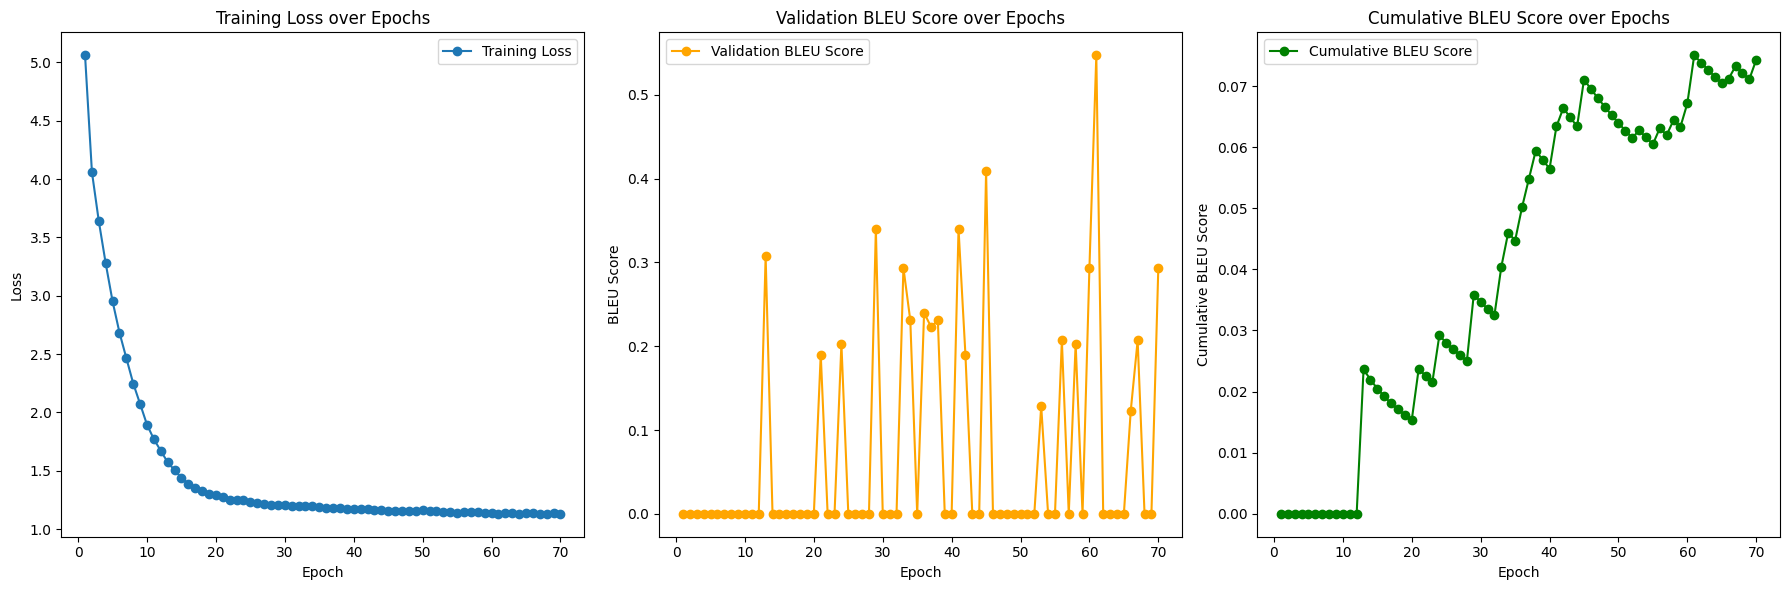

In [22]:

# Train our model
train_model(preload_epoch=None)